In [1]:
import time
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Import packages for visualization of results
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
# Iport packages for evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
df_1 = pd.read_csv(r"C:\Users\flore\OneDrive\Documents\CSUN\Fall24\COMP_541\Project\VideoGame\games.csv")

In [3]:
df_2 = pd.read_csv(r"C:\Users\flore\OneDrive\Documents\CSUN\Fall24\COMP_541\Project\VideoGame\all_games.csv")

In [4]:
df_1.columns = ['Name','Release date','Estimated Owners','Peak CCU','Required age','Price','Unknown1',
              'Unknown2','About the game','Supported languages','Full audio languages','Reviews','Header Image','Website',
              'Support url','Support email','Windows','Mac', 'Linux','User score','Metacritic url'
              ,'Positive','Negative','Score rank','Achievements','Recommendations','Unknown3','Notes',
              'Average playtime forever','Average playtime two weeks','Median playtime forever','Median playtime two weeks',
              'Developers','Publishers','Categories','Genres','Tags','Screenshots','Movies']

In [5]:
df_2.columns = ['Name','Platform','Release Date','Summary','Meta Score','User Review']

In [6]:
df_1 = df_1.drop(['Developers','User score','Average playtime forever','Average playtime two weeks','Median playtime forever','Median playtime two weeks','Recommendations','Estimated Owners','About the game','Reviews','Unknown1','Unknown2','Unknown3', 'Supported languages','Full audio languages','Header Image' ,'Website', 'Support url', 'Support email', 'Notes', 'Metacritic url', 'Achievements', 'Screenshots', 'Movies','Publishers','Categories','Tags'], axis=1)

In [7]:
df_2 = df_2.drop(['Summary','Release Date','Platform','User Review'], axis=1)

In [8]:
VG_dataset = pd.merge(df_1, df_2, on='Name', how='inner')

In [9]:
len_VG_dataset = len(VG_dataset)
print(f"Number of matching instances in 'Name': {len_VG_dataset}")

Number of matching instances in 'Name': 5860


In [10]:
print(VG_dataset.isna().sum())

Name            0
Release date    0
Peak CCU        0
Required age    0
Price           0
Windows         0
Mac             0
Linux           0
Positive        0
Negative        0
Score rank      0
Genres          3
Meta Score      0
dtype: int64


In [11]:
VG_dataset = VG_dataset.dropna()

In [12]:
VG_dataset = VG_dataset.drop(['Name'], axis = 1)

In [13]:
VG_dataset.shape

(5857, 12)

In [14]:
VG_dataset['Release date'] = VG_dataset['Release date'].str.extract(r'(\d{4})')
VG_dataset['Release date'] = pd.to_numeric(VG_dataset['Release date'], errors='coerce')
VG_dataset = VG_dataset[VG_dataset['Release date'] >= 2014]


In [15]:
len_VG_filter_by_year = len(VG_dataset)
print(f"Number of Games instances release after 2014': {len_VG_filter_by_year}")

Number of Games instances release after 2014': 4573


In [16]:
VG_dataset['Genres'] = VG_dataset['Genres'].str.split(',')
unique_tags = set(tag for sublist in VG_dataset['Genres'] for tag in sublist)
one_hot_encoded_genres = VG_dataset['Genres'].str.join('|').str.get_dummies()
VG_dataset = pd.concat([VG_dataset, one_hot_encoded_genres], axis=1)
VG_dataset.drop('Genres', axis=1, inplace=True) #don't need 'Genres' feature any more

In [17]:
Q1 = VG_dataset['Negative'].quantile(0.25)
Q3 = VG_dataset['Negative'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
VG_outliers_filter = VG_dataset[(VG_dataset['Negative'] >= lower_bound) & (VG_dataset['Negative'] <= upper_bound)]

In [18]:
total_outliers = len(VG_dataset) - len(VG_outliers_filter)
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Total Number of Outliers: {total_outliers}")

Lower Bound: -6519.0
Upper Bound: 11465.0
Total Number of Outliers: 693


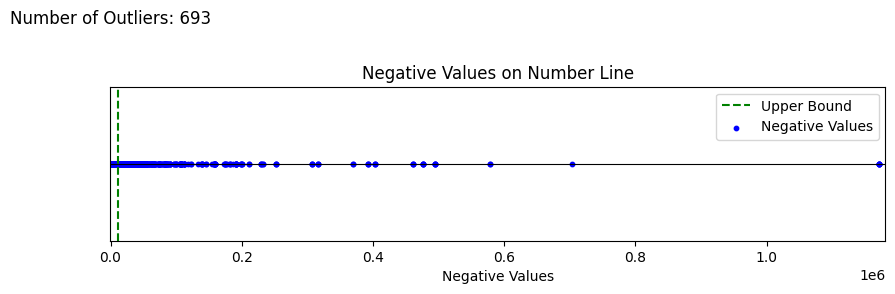

In [19]:
plt.figure(figsize=(10, 2))
plt.title("Negative Values on Number Line")
plt.axhline(0, color='black', lw=0.8)  
plt.text(0, 0.1, f'Number of Outliers: {total_outliers}', fontsize=12, ha='center', color='black')
plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.scatter(VG_dataset['Negative'], np.zeros(len(VG_dataset)), color='blue', label='Negative Values', s=10)
plt.xlim(VG_dataset['Negative'].min() - 100, VG_dataset['Negative'].max()+10000)  # x-axis limits
plt.yticks([])  
plt.xlabel("Negative Values")
plt.legend()
plt.grid(False)
plt.show()

In [20]:
VG_dataset = VG_outliers_filter

In [21]:
scaler = MinMaxScaler()
normalization_data = scaler.fit_transform(VG_dataset[['Release date', 'Peak CCU','Required age','Price', 'Positive', 'Negative','Score rank','Meta Score']])
VG_dataset[['Release date', 'Peak CCU','Required age','Price', 'Positive', 'Negative', 'Score rank','Meta Score']] = normalization_data

In [22]:
genre_columns = VG_dataset.columns[11:]
threshold = 0.10 * len(VG_dataset)
filtered_genres = [col for col in genre_columns if VG_dataset[col].sum() >= threshold]
columns_to_keep = VG_dataset.columns[1:11].tolist() + filtered_genres
VG_dataset = VG_dataset[columns_to_keep]

In [23]:
unique_windows = VG_dataset['Windows'].unique()
print(unique_windows)

[ True]


In [24]:
# Remove the feature 'Window' because all the instance has the same value 
# redundant feature 
VG_dataset= VG_dataset.drop(['Windows'], axis=1)

In [25]:
correlation_matrix = VG_dataset.corr()
meta_score_correlation = correlation_matrix['Meta Score']
print("Correlation with 'Meta Score':")
print(meta_score_correlation)

Correlation with 'Meta Score':
Peak CCU        0.101408
Required age   -0.084234
Price           0.107857
Mac             0.091121
Linux           0.085801
Positive        0.004695
Negative        0.271781
Score rank      0.017465
Meta Score      1.000000
Action         -0.035465
Adventure       0.008087
Casual          0.001627
Indie           0.046899
RPG             0.041915
Simulation     -0.016598
Strategy        0.012977
Name: Meta Score, dtype: float64


In [26]:
low_correlation_features = meta_score_correlation[abs(meta_score_correlation) < 0.015].index.tolist()
VG_dataset.drop(columns=low_correlation_features, inplace=True)

In [27]:
VG_dataset.head()

,Peak CCU,Required age,Price,Mac,Linux,Negative,Score rank,Meta Score,Action,Indie,RPG,Simulation
11,0.000070,0.000000,0.074954,False,False,0.018055,0.007046,0.657534,1,1,1,0
12,0.000279,0.000000,0.004950,False,False,0.181683,0.034584,0.821918,1,1,0,0
13,0.000279,0.000000,0.004950,False,False,0.181683,0.034584,0.739726,1,1,0,0
16,0.000070,0.000000,0.124956,False,False,0.036633,0.010569,0.397260,0,1,0,0
17,0.003175,0.722222,0.199960,False,False,0.184300,0.008988,0.794521,0,0,1,0


In [28]:
VG_dataset.shape

(3880, 12)

In [29]:
fixed_num_instances = len(VG_dataset)
VG_dataset = VG_dataset.sample(n=fixed_num_instances, random_state=42)

In [30]:
y =VG_dataset['Meta Score']

In [31]:
X = VG_dataset.drop(['Meta Score'], axis=1)

In [32]:
X = pd.DataFrame(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [35]:
param_grid = {
    'n_neighbors': [3,5,7,9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [36]:
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

In [37]:
st=time.time()
grid_search.fit(X_train_scaled, np.ravel(y_train))
et = time.time()
elapsed_time = et - st
print(f"Run time: {elapsed_time}")

Run time: 2.772475004196167


In [38]:
best_knn = grid_search.best_estimator_
y_pred_test = best_knn.predict(scaler.transform(X_test))
y_pred_train = best_knn.predict(scaler.transform(X_train))

In [39]:
min_value = min(min(y_test), min(y_pred_test))
max_value = max(max(y_test), max(y_pred_test))

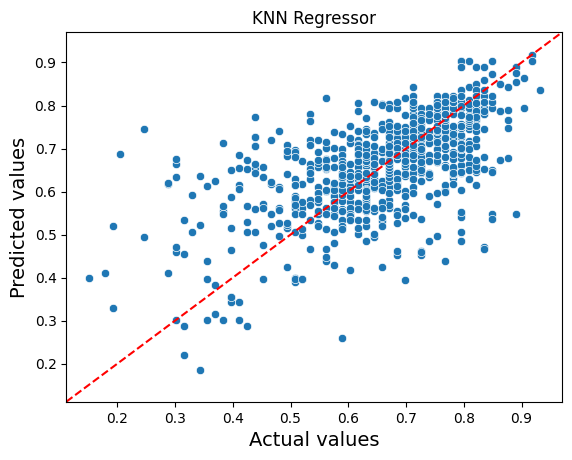

In [40]:
p = sns.scatterplot(x=y_test, y=y_pred_test)
plt.title("KNN Regressor")
p.set_xlabel("Actual values", fontsize=14)
p.set_ylabel("Predicted values", fontsize=14)
plt.axline((min_value,min_value), (max_value, max_value), color='r', ls='--')

In [41]:
print("MSE: ", metrics.mean_squared_error(y_test, y_pred_test))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred_test))
print("R sqaure: ", metrics. r2_score(y_test, y_pred_test))

MSE:  0.01236329866013047
MAE:  0.08017543383278973
R sqaure:  0.3118740547140526


In [42]:
train_accuracy = r2_score(y_train, y_pred_train)
test_accuracy = r2_score(y_test, y_pred_test)

print("Train Accuracy (R^2):", train_accuracy)
print("Test Accuracy (R^2):", test_accuracy)

Train Accuracy (R^2): 0.9430140563227308
Test Accuracy (R^2): 0.3118740547140526
